<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02456 Deep Learning</h2>
<p style="text-align: center;">Authors: s233912, s253167, s253093, s233910</p>

In [1]:
import os
import glob
import nbformat
import pyarrow
import pyarrow.parquet
import pandas as pd
import numpy as np
from pyproj import Transformer
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn

from src.visualization.visualize_trajectories import visualize_trajectories_efficient, visualize_trajectories_to_compare
from itertools import product
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime
import pickle
import matplotlib.pyplot as plt

import plotly.express as px
from pyproj import Transformer

import os
import joblib

import importlib
import json
import itertools
import torch.nn.functional as F


TRAIN_DIR = 'data/aisdk/train/aisdk_2025'
TEST_DIR  = 'data/aisdk/test/aisdk_2025'
VAL_DIR   = 'data/aisdk/val/aisdk_2025'


# 0. Prelude
This notebook contains a compilation of the code for the final project of the course 02456 Deep Learning. 

# 1. Introduction

Ship trajectories observed through AIS (Automatic Identification System) data show a wide variety of behaviors: vessels follow different routes, move at different speeds, and react differently to geography, traffic, and navigation decisions. This diversity makes it difficult to train a single model to accurately predict future motion for every vessel in a region.

Instead, we follow an approach inspired by an approach proposed in [An AIS-based deep learning framework for regional ship behavior prediction](https://www.sciencedirect.com/science/article/pii/S0951832021003409): rather than modeling all ship behavior at once, we first cluster behaviors and then train specialized models for each type of movement.

Our goal is to predict a vessel's future 30-minute trajectory from its past 30-minute motion.

**Methods:**
1. Cluster historical trajectories using an RAE and HDBSCAN.
2. Classify each past 30-minute segment to a behaviour cluster.
3. Train one prediction model per cluster.
4. Predict future motion using the predicted clsuter and its corresponding local model.

# 2. Data

The data processing workflow is implemented in **`src/data_processing/data_pipeline`**.

The raw AIS dataset is obtained from the Danish AIS system via [aisdata.ais.dk](http://aisdata.ais.dk/) and includes vessel positions, speed over ground, course, and MMSI identifiers. For tractability, the analysis is restricted to Cargo vessels active on the 1st and 2nd of August.

## 2.1 Initial Cleaning
Initial preprocessing consists of:
- Removing duplicate `(Timestamp, MMSI)` messages  
- Filtering to Cargo vessels and Class A/B AIS units  
- Converting latitude/longitude to UTM coordinates  
- Applying basic consistency checks and noise reduction  

After this stage, the cleaned AIS points were visualized as follows:


(np.float64(-0.5), np.float64(1633.5), np.float64(1399.5), np.float64(-0.5))

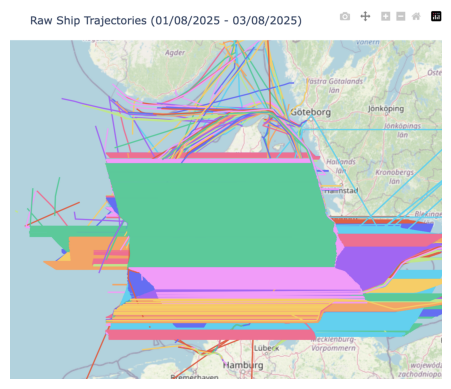

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("plots/rae_visualizations/00_raw_traj.png")
plt.imshow(img)
plt.axis('off')

## 2.2 Trajectory-Level Cleaning
Further processing is performed at the trajectory level:
- Segmenting AIS points into trajectories based on long gaps, stops, or abnormal jumps  
- Dropping segments that are stationary or too short  
- Excluding trajectories containing missing motion values (SOG or COG)

After this trajectory-level cleanup, the resulting set of valid trajectories was visualized:

(np.float64(-0.5), np.float64(897.5), np.float64(799.5), np.float64(-0.5))

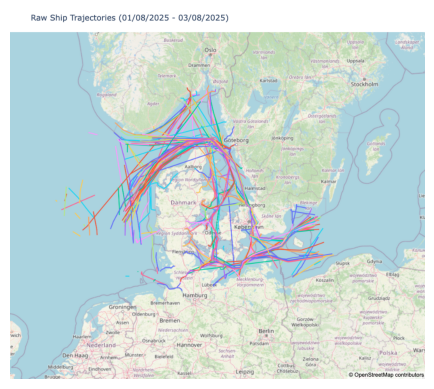

In [3]:
img = mpimg.imread("plots/rae_visualizations/00_proc_traj.png")
plt.imshow(img)
plt.axis('off')

Finally, the data are split into global subsets of 70% training, 15% validation, and 15% test. All feature standardization is based solely on the training split and applied consistently to the remaining subsets. These processed and standardized splits are saved and serve as the foundation for all subsequent stages of the project.

# 3. Clustering Vessel Behaviours

With the cleaned and standardized AIS trajectories prepared, the next step is to discover underlying patterns of vessel movement. Instead of treating all trajectories as a single homogeneous dataset, the aim is to identify groups of similar behaviour that can later support specialised prediction models. To achieve this, trajectory representations are learned using a recurrent autoencoder and subsequently clustered.

## 3.1 Recurrent AutoEncoder

Trajectory clustering requires fixed-length numerical representations, but AIS trajectories vary in length and dynamics. A recurrent autoencoder (RAE) is therefore used to encode each trajectory into a compact latent vector that captures its motion characteristics.

The model consists of a GRU-based encoder that processes each trajectory and outputs a latent representation, and a decoder trained to reconstruct the original sequence. By optimizing the reconstruction loss, the encoder learns representations that reflect the trajectory’s underlying structure. These latent vectors form the basis for the clustering stage that follows.


In [4]:
from src.models import RAE
importlib.reload(RAE)
from src.visualization.visualize_rae import visualize_rae_latent_space

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class TrajectoryDataset(Dataset):
    def __init__(self, trajectories):
        self.trajectories = trajectories
    
    def __len__(self):
        return len(self.trajectories)
    
    def __getitem__(self, idx):
        traj = torch.FloatTensor(self.trajectories[idx])
        return traj
    
def pad_trajectories(batch):
    lengths = torch.tensor([len(traj) for traj in batch])
    padded = pad_sequence(batch, batch_first=True, padding_value=0.0)

    lengths, perm_idx = lengths.sort(descending=True)
    padded = padded[perm_idx]

    return padded, lengths

In [5]:
# Start with loading the data
train = pd.read_parquet(TRAIN_DIR)
val = pd.read_parquet(VAL_DIR)
test = pd.read_parquet(TEST_DIR)

# Turn train and val sets into lists of trajectories
train_trajectories = []
    
for traj_id in train['Trajectory'].unique():
    traj_data = train[train['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    train_trajectories.append(features)

print(f"Total trajectories: {len(train_trajectories)}")

val_trajectories = []
    
for traj_id in val['Trajectory'].unique():
    traj_data = val[val['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    val_trajectories.append(features)

print(f"Total trajectories: {len(val_trajectories)}")

test_trajectories = []
    
for traj_id in test['Trajectory'].unique():
    traj_data = test[test['Trajectory'] == traj_id].sort_values('Timestamp')
    features = traj_data[['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']].values
    test_trajectories.append(features)

print(f"Total trajectories: {len(test_trajectories)}")

Total trajectories: 777
Total trajectories: 167
Total trajectories: 167


In [6]:
train_dataset = TrajectoryDataset(train_trajectories)
val_dataset = TrajectoryDataset(val_trajectories)

In [7]:
# Load the trained model
checkpoint = torch.load(os.path.join('checkpoints', 'rae', 'best_rae_model.pth'))

# Get hyperparameters 
hp = checkpoint['hyperparameters']

model = RAE.RecurrentAutoencoder(
    input_dim=hp['feature_size'],
    hidden_dim=hp['hidden_size'],
    latent_dim=hp['latent_dim'],
    num_layers_encoder=hp['encoder_layers'],
    num_layers_decoder=hp['decoder_layers'],
    dropout=hp['dropout']
).to(device)


# Load the trained weights
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # Set to evaluation mode

print(f"Model loaded! Best val_loss: {checkpoint['val_loss']}")
print(f"Trained for {checkpoint['epoch']} epochs")

Model loaded! Best val_loss: 1.5638
Trained for 30 epochs


Collected 167 samples for visualization


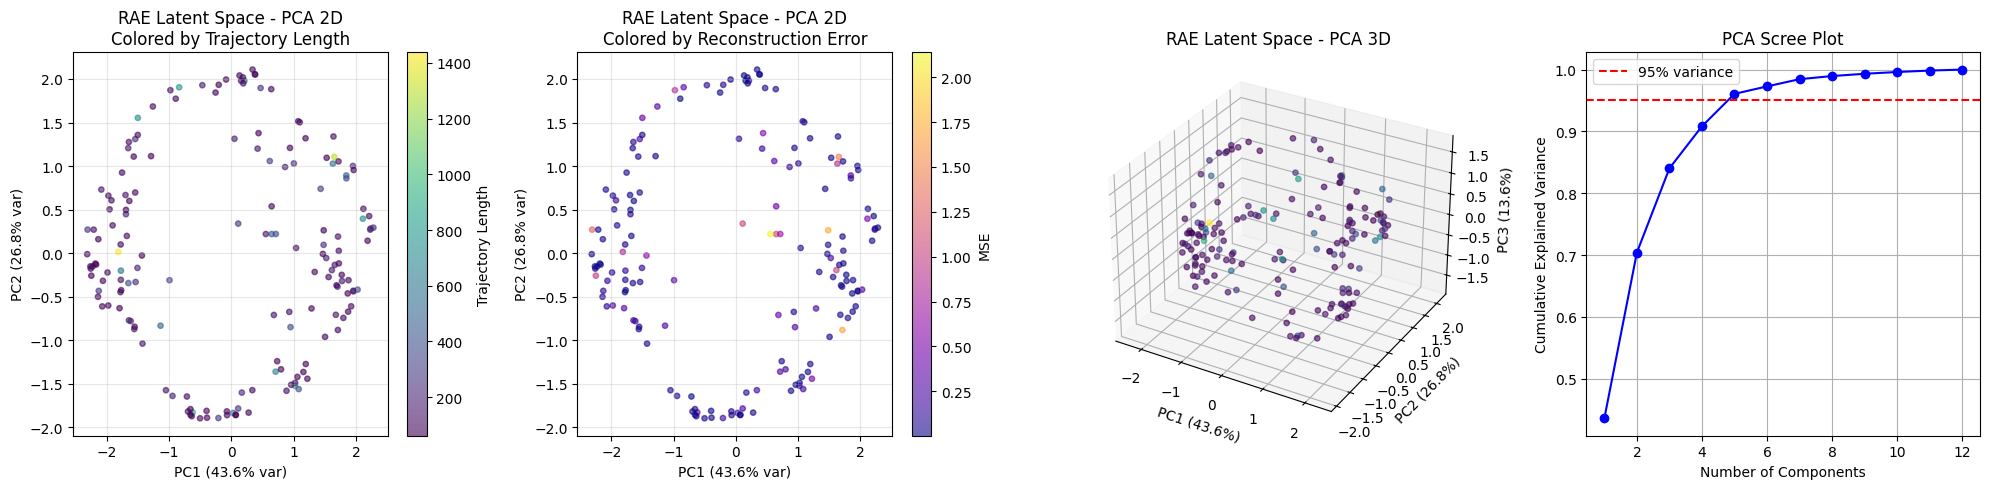

Computing t-SNE... (this may take a minute)


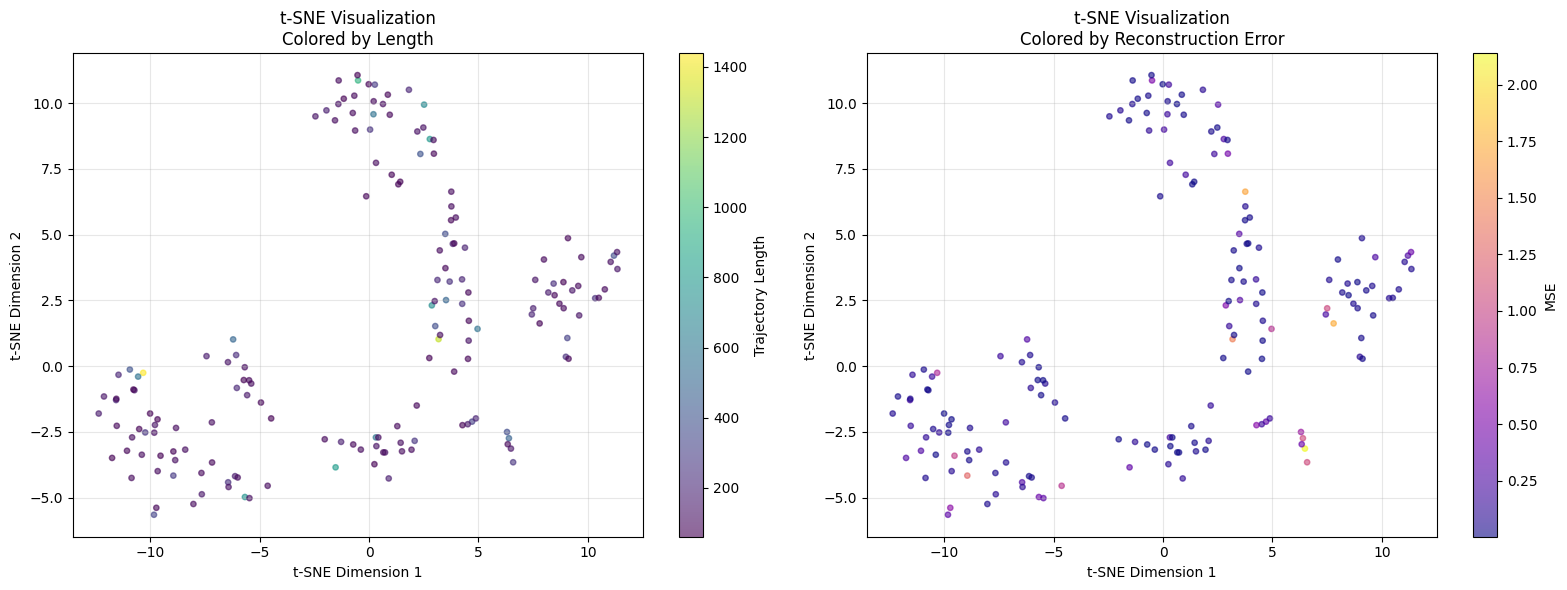

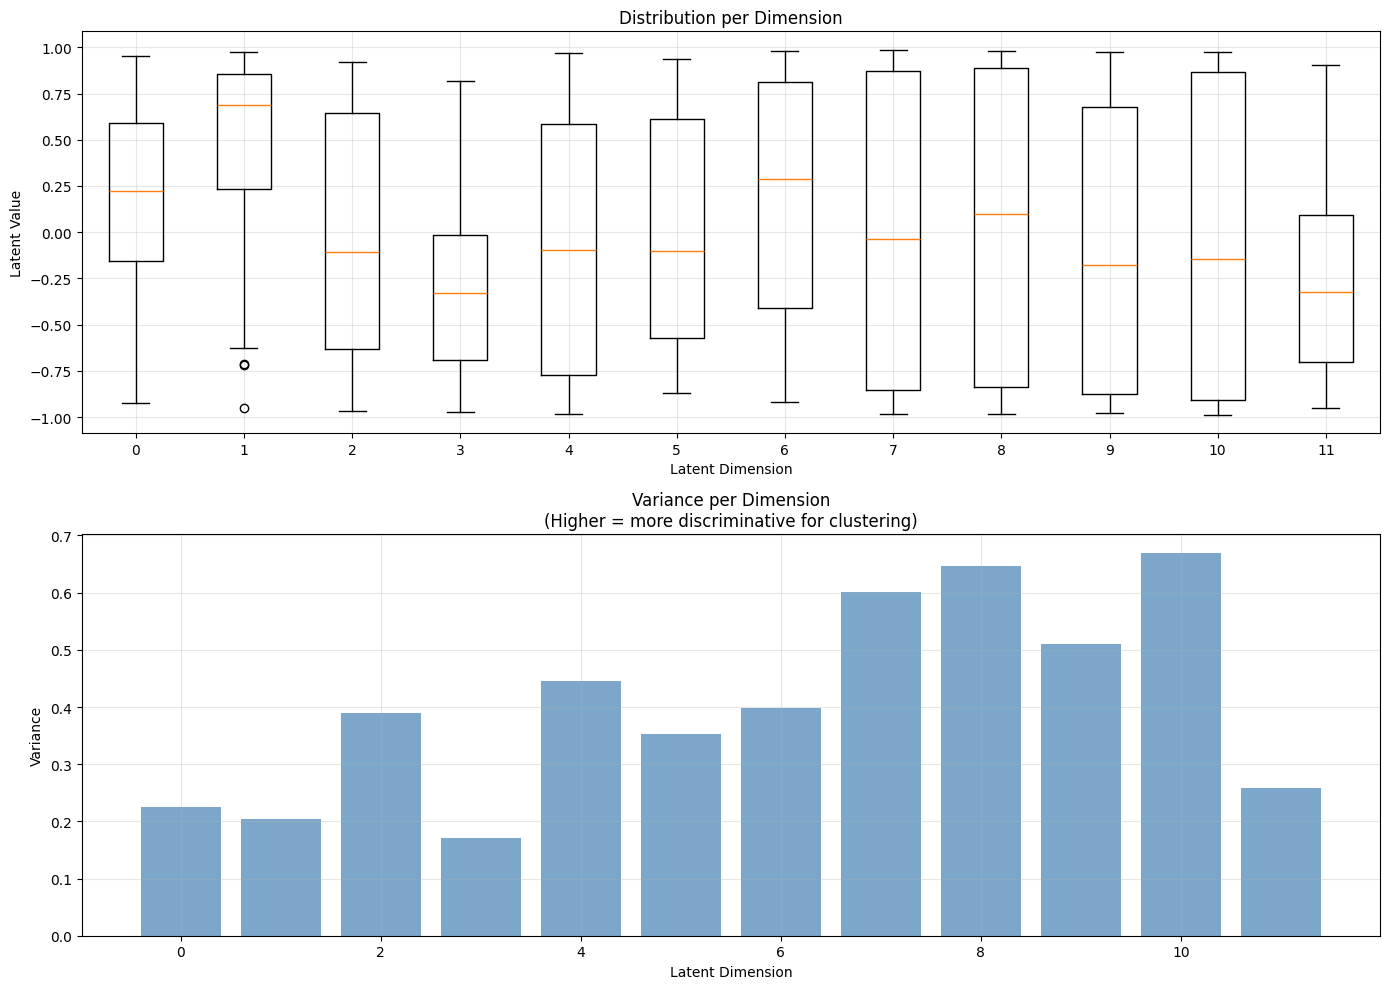

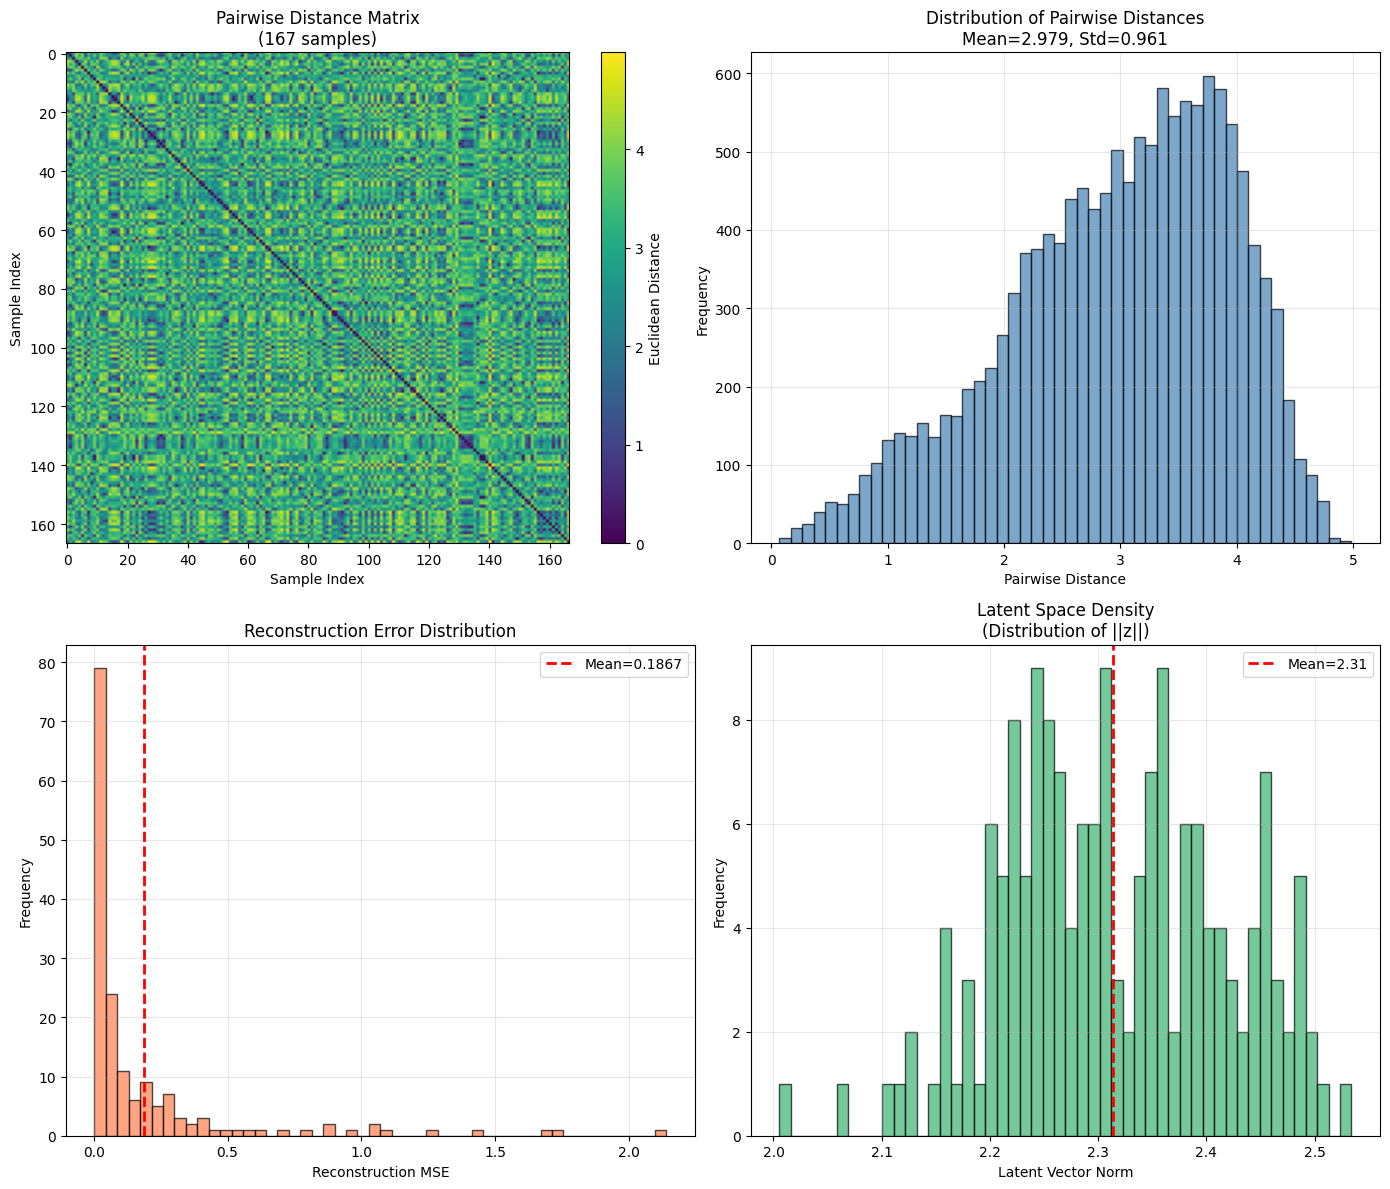

Generating reconstruction examples...


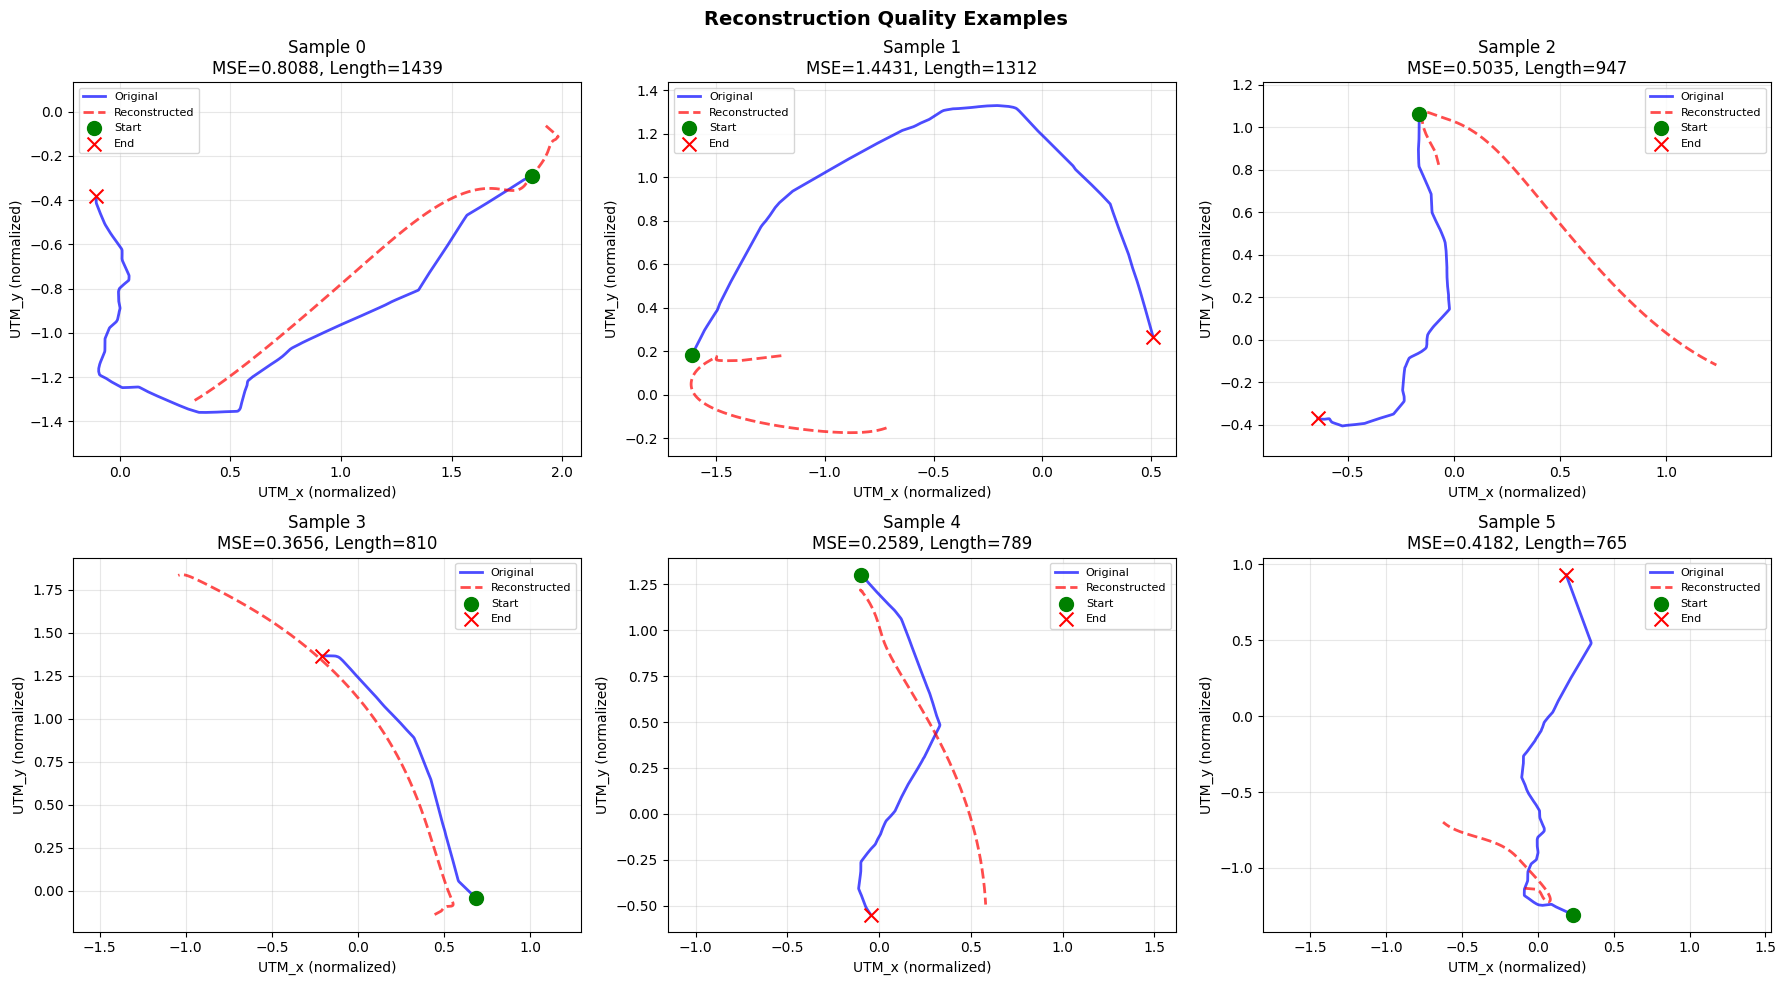

Running K-means clustering preview...


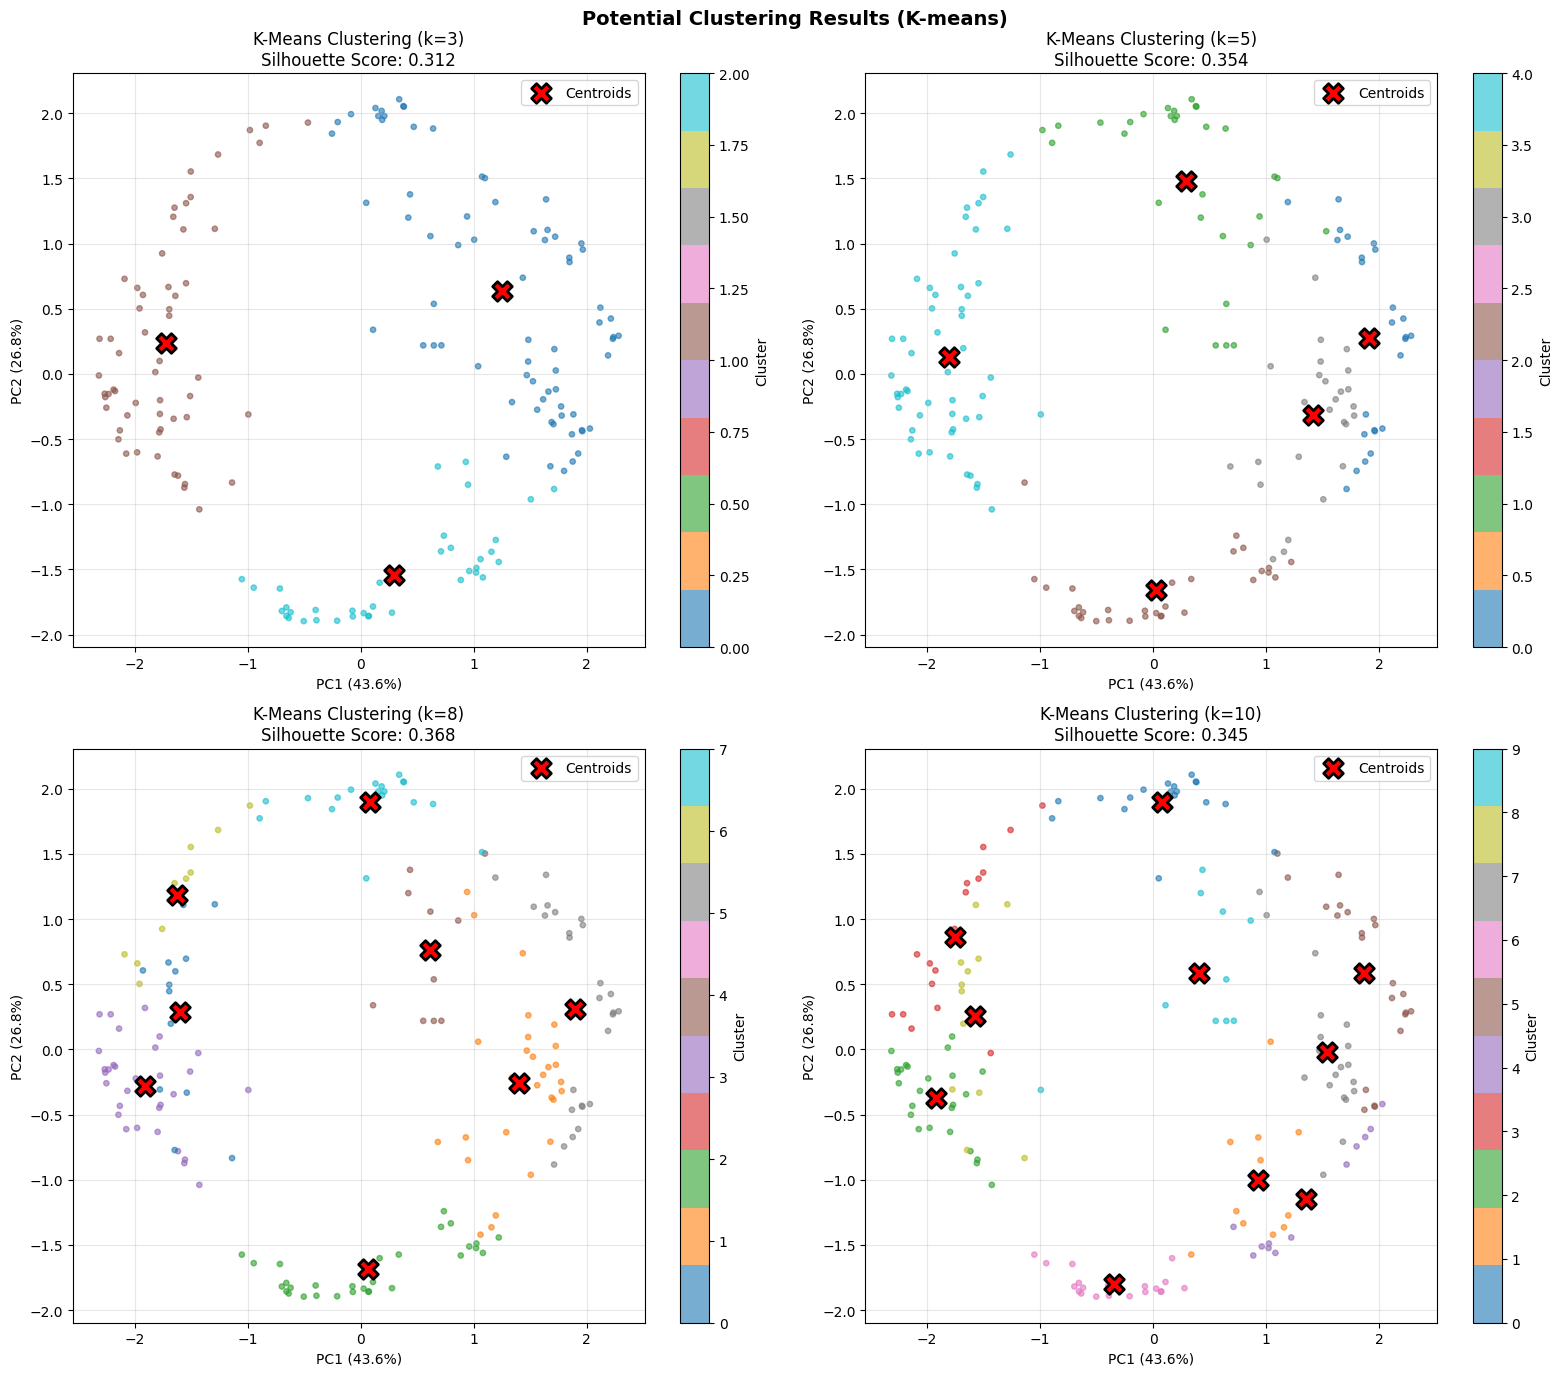


RAE LATENT SPACE ANALYSIS SUMMARY

📊 Dataset Statistics:
  Total samples: 167
  Latent dimensions: 12
  Avg trajectory length: 188.4 ± 209.2

🎯 Latent Space Statistics:
  Mean: 0.0062
  Std:  0.6685
  Norm (mean): 2.3137
  Norm (std):  0.1016

📈 Reconstruction Quality:
  Mean MSE: 0.186716
  Std MSE:  0.340856
  Min MSE:  0.002443
  Max MSE:  2.139418

🔍 Clustering Indicators:
  Mean pairwise distance: 2.9793
  Std pairwise distance:  0.9614
  Variance per dim (mean): 0.4059
  Variance per dim (std):  0.1663
  PCA 95% variance: 5 components
  Active dimensions: 12/12 (100.0%)

🏥 Health Assessment:
  ✅ Overall std > 0.3: Good spread
  ⚠️  High reconstruction error: May need more training
  ✅ Good separation between samples
  ✅ 100% dimensions active: Good capacity usage
  ✅ Good variance: Suitable for clustering

📊 Overall Health Score: 4/5
  🎉 EXCELLENT - Ready for clustering!

✅ All visualizations saved to 'plots/rae_visualizations/'


In [8]:
# Create a visualization loader
viz_loader = DataLoader(
    val_dataset,
    batch_size=256,
    shuffle=False,
    collate_fn=pad_trajectories
)

# Run RAE visualization
rae_results = visualize_rae_latent_space(
    model=model,  # Your trained RAE model
    data_loader=viz_loader,
    device=device,
    save_dir='plots/rae_visualizations',
    max_samples=5000
)

# Access results
latents = rae_results['latents']
health_score = rae_results['health_score']
pca_transform = rae_results['pca_2d']

The trained autoencoder produces stable and well-structured latent representations. The latent space shows low variance drift (mean ≈ 0.006) and consistent vector norms, indicating that trajectories occupy a compact manifold suitable for clustering. Reconstruction errors remain low on average (MSE ≈ 0.19), with only a small number of harder-to-reconstruct cases. Pairwise distances in the latent space show clear separation between samples, and automated quality checks confirm that the representations are well suited for downstream clustering.


## 3.2 Clustering with HDBSCAN

The latent trajectory representations from the RAE are clustered using HDBSCAN, a density-based algorithm capable of identifying clusters of irregular shape and varying density while labeling outliers as noise.

Clustering is performed directly in the latent space. HDBSCAN automatically infers the number of clusters based on density structure, without requiring a predefined \(k\). Samples that do not belong to any coherent dense region are assigned to a noise class and excluded from later modeling. The resulting clusters capture distinct vessel movement patterns and form the basis for the subsequent classification and trajectory prediction components.

The clustering procedure is implemented in `models/train_hdbscan.ipynb`, and the resulting cluster labels are stored under `data/aisdk/processed/clustered/` for later use.

HDBSCAN identified **10 behaviour clusters**, shown in the t-SNE visualization below:

![HDBSCAN t-SNE plot](plots/rae_visualizations/clustering_results.png)



# 4. Classifying Vessel Behaviours

In [9]:
import json
from pathlib import Path
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.models.classification_rnn import ClassificationRNN

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

import matplotlib.pyplot as plt

device = "mps" if torch.backends.mps.is_available() else "cpu"

# Best parameters for the classification
best_params = {
    'hidden_size': 128,
    'num_layers': 1,
    'dropout': 0.1,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'batch_size': 256,
    'epochs': 20,
    'grad_clip': 1.0
 }

# # point to your best_params file
# json_path = Path("checkpoints/classifier") / \
#             "best_params_20251202_183956.json"  # adjust name if needed

# with open(json_path, "r") as f:
#     best_params = json.load(f)

After clustering the trajectories, a classifier is trained to assign new trajectory segments to their most likely behaviour cluster. The classifier operates on past 30-minute windows—generated by sliding a fixed-length window across each trajectory, and predicts the cluster label discovered during the unsupervised clustering stage. In the following chapter, the trained classifier is loaded and its performance evaluated; the full training procedure is documented in `models/train_classifier.ipynb`.

HDBSCAN identified **10 behaviour clusters** in the latent space. After tuning the classifier’s hyperparameters (`hidden size`, `number of layers`, `dropout`, `learning rate`, and `weight decay`), the best-performing model used the following settings:

In [10]:
best_params

{'hidden_size': 128,
 'num_layers': 1,
 'dropout': 0.1,
 'lr': 0.001,
 'weight_decay': 0.0001,
 'batch_size': 256,
 'epochs': 20,
 'grad_clip': 1.0}

In [11]:
# Start with loading the data
def make_loaders(batch_size):
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

train_traj = np.load(os.path.join("data/aisdk/processed/windows/train_trajectories.npz"))
val_traj = np.load(os.path.join("data/aisdk/processed/windows/val_trajectories.npz"))
test_traj = np.load(os.path.join("data/aisdk/processed/windows/test_trajectories.npz"))

X_train, X_val = train_traj["past"], val_traj["past"]
y_train, y_val = train_traj["cluster"], val_traj["cluster"]

X_train_t = torch.tensor(X_train, dtype=torch.float32)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

train_loader, val_loader = make_loaders(256)


print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Unique clusters:", np.unique(y_train))

X_train shape: (1702, 30, 5)
y_train shape: (1702,)
Unique clusters: [-1  3]


In [12]:
# Identify majority class in train and val to build a baseline
train_classes, train_counts = np.unique(y_train, return_counts=True)
train_majority_cls = int(train_classes[np.argmax(train_counts)])

val_classes, val_counts = np.unique(y_val, return_counts=True)
val_majority_cls = int(val_classes[np.argmax(val_counts)])

print(f"Train majority class: {train_majority_cls} ({train_counts.max()} samples)")
print(f"Val majority class:   {val_majority_cls} ({val_counts.max()} samples)")

# Build constant logits that always predict the majority class
# We set a large positive logit for the majority class, zeros elsewhere
crit = nn.CrossEntropyLoss()

def constant_majority_loss_and_acc(X_t, y_t, majority_cls, num_classes):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    X_t = X_t.to(device)
    y_t = y_t.to(device)

    N = X_t.shape[0]
    # Create logits: shape (N, num_classes)
    logits = torch.zeros((N, num_classes), dtype=torch.float32, device=device)
    logits[:, majority_cls] = 10.0  # strong preference for the majority class

    # Loss
    loss = crit(logits, y_t).item()

    # Accuracy
    preds = logits.argmax(dim=1)
    acc = (preds == y_t).float().mean().item()
    return loss, acc

num_classes = int(y_train.max() + 1)

train_loss_baseline, train_acc_baseline = constant_majority_loss_and_acc(
    X_train_t, y_train_t, train_majority_cls, num_classes
)
val_loss_baseline, val_acc_baseline = constant_majority_loss_and_acc(
    X_val_t, y_val_t, val_majority_cls, num_classes
)

print("\nMajority-class baseline:")
print(f"  Train -> Loss: {train_loss_baseline:.4f}, Acc: {train_acc_baseline:.4f}")
print(f"  Val   -> Loss: {val_loss_baseline:.4f}, Acc: {val_acc_baseline:.4f}")

Train majority class: 3 (1557 samples)
Val majority class:   3 (1557 samples)

Majority-class baseline:
  Train -> Loss: 0.0001, Acc: 0.9148
  Val   -> Loss: 0.0001, Acc: 0.9148


In [13]:
# Check how many points are in each cluster for train and val sets
unique, counts = np.unique(y_train, return_counts=True)
train_cluster_counts = dict(zip(unique, counts))
print("\nTraining set cluster distribution:")
for cluster, count in train_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")  

unique, counts = np.unique(y_val, return_counts=True)
val_cluster_counts = dict(zip(unique, counts))
print("\nValidation set cluster distribution:") 
for cluster, count in val_cluster_counts.items():
    print(f"  Cluster {cluster}: {count} samples")


Training set cluster distribution:
  Cluster -1: 145 samples
  Cluster 3: 1557 samples

Validation set cluster distribution:
  Cluster -1: 145 samples
  Cluster 3: 1557 samples


In [14]:
# Load the model
checkpoint = torch.load('checkpoints/classifier/classification_rnn_model.pt')
state_dict = torch.load('checkpoints/classifier/classification_rnn_model.pt', map_location=device)

model = ClassificationRNN(
        input_size=5,
        hidden_size=best_params["hidden_size"],
        num_classes=10, 
).to(device)

model.load_state_dict(state_dict)


<All keys matched successfully>

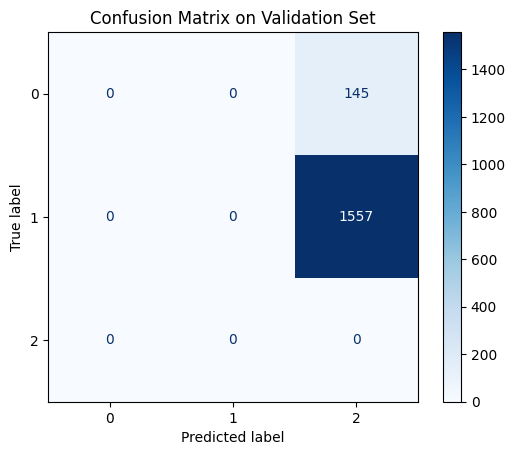

In [15]:
# Make confusion matrix on validation set
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


model.eval()
all_preds = []
with torch.no_grad():
    for xb, _ in val_loader:
        xb = xb.to(device)
        logits = model(xb)
        preds = logits.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())   
cm = confusion_matrix(y_val, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()

Although the classifier trained stably, its absolute performance was poor. As shown in the confusion matrix, the model predicts almost all samples as belonging to the dominant noise cluster. When compared to a majority-class baseline—which simply assigns every sample to this cluster—the classifier performs only marginally better. This outcome suggests that the past 30-minute window may not provide enough discriminative information for reliable cluster assignment, or that the heavily imbalanced cluster structure is difficult to learn given the size of the dataset.


# 5. Trajectory Prediction

Having classified vessel behaviour, the next step is to predict future motion using the cluster-specific predictors. The objective is to forecast the next 30 minutes of a vessel’s trajectory based on its past 30 minutes. As before, each sample is constructed with a sliding-window approach, where the past window is the input and the subsequent window is the prediction target, both derived from the resampled and standardized trajectories.

The prediction models were trained in `models/train_prediction_rnn.ipynb`. In the following sections, the focus will be on one cluster-specific model (from a total of 10). The pipeline loads the shared components (scaler, RAE, and classifier), classifies all test windows, and then selects those assigned to a chosen cluster (here, cluster 9). For these windows, the corresponding GRU-based sequence-to-sequence predictor is loaded and used to generate 30-minute future trajectories, compute mean squared error, and store the predictions.

Finally, a single example trajectory from this cluster is visualized: the past segment, the ground-truth future, and the predicted future are unscaled back to UTM coordinates and plotted together to illustrate how the predictor behaves for this particular model.

In [16]:
from src.models.trajectory_predictor import TrajectoryPredictor

In [17]:
# Overwrite the y with the future sequence
X_test, y_test = test_traj["past"], test_traj["future"]

y_test_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

In [18]:
# Reinstate scaler
obj = joblib.load(os.path.join("data", "aisdk", "scaler", "scaler_aisdk_2025.pkl"))

saved_feature_names = None

if isinstance(obj, StandardScaler):
    scaler = obj
    # If you stored feature names separately, keep as None here
    print("Loaded StandardScaler object from joblib.")
elif isinstance(obj, dict):
    scaler = StandardScaler()
    scaler.mean_ = np.asarray(obj['mean'])
    scaler.scale_ = np.asarray(obj['scale'])
    saved_feature_names = obj.get('feature_names', None)
    print("Reconstructed StandardScaler from dict params.")
else:
    raise TypeError(f"Unexpected scaler payload type: {type(obj)}")

print("Scaler ready. n_features:", scaler.mean_.shape[0],
      "| feature names:", (list(saved_feature_names) if saved_feature_names is not None else "None"))

Loaded StandardScaler object from joblib.
Scaler ready. n_features: 5 | feature names: None


In [19]:
# Reinstate autoencoder
ae_checkpoint = torch.load('checkpoints/rae/best_rae_model.pth')

# Recreate the model architecture
rae = RAE.RecurrentAutoencoder(
    input_dim=ae_checkpoint['hyperparameters']['feature_size'],
    hidden_dim=ae_checkpoint['hyperparameters']['hidden_size'],
    latent_dim=ae_checkpoint['hyperparameters']['latent_dim'],
    num_layers_encoder=ae_checkpoint['hyperparameters']['encoder_layers'],
    num_layers_decoder=ae_checkpoint['hyperparameters']['decoder_layers'],
    dropout=ae_checkpoint['hyperparameters']['dropout']
).to(device)

rae.load_state_dict(ae_checkpoint['model_state_dict'])
rae.eval()

RecurrentAutoencoder(
  (encoder): GRU(5, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc_latent): Linear(in_features=128, out_features=12, bias=True)
  (bn_latent): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
  (fc_z_to_hidden): Linear(in_features=12, out_features=128, bias=True)
  (decoder): GRU(5, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc_output): Linear(in_features=64, out_features=5, bias=True)
)

In [20]:
# Reinstate classifier
c_checkpoint = torch.load('checkpoints/classifier/classification_rnn_model.pt')

c_rnn = ClassificationRNN(
    input_size=5,
    hidden_size=128,
    num_layers=5,
    num_classes=10,
    bidirectional=True,
    rnn_dropout=0.1
).to(device)

c_rnn.load_state_dict(c_checkpoint)
c_rnn.eval()

ClassificationRNN(
  (gru): GRU(5, 128, num_layers=5, batch_first=True, dropout=0.1, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=10, bias=True)
  )
)

In [21]:
# Reinstate the predictor
p_checkpoint = torch.load('checkpoints/predictor/trajectory_cluster-1.pt')

p_rnn = TrajectoryPredictor(
    input_dim=p_checkpoint['cfg']['input_dim'],
    hidden_dim=p_checkpoint['cfg']['hidden_dim'],
    output_dim=p_checkpoint['cfg']['output_dim'],
    num_layers_encoder=p_checkpoint['cfg']['num_layers_encoder'],
    num_layers_decoder=p_checkpoint['cfg']['num_layers_decoder'],
    attn_dim=p_checkpoint['cfg']['attn_dim']
).to(device)

p_rnn.load_state_dict(p_checkpoint['model_state'])
p_rnn.eval()

TrajectoryPredictor(
  (encoder): GRU(5, 128, batch_first=True, bidirectional=True)
  (hidden_enc_to_dec): Linear(in_features=256, out_features=128, bias=True)
  (attn_mlp): Linear(in_features=384, out_features=64, bias=True)
  (attn_v): Linear(in_features=64, out_features=1, bias=False)
  (decoder): GRU(261, 128, batch_first=True)
  (hidden_to_output): Linear(in_features=389, out_features=5, bias=True)
)

In [22]:
test_traj = np.load("data/aisdk/processed/windows/test_trajectories.npz")

X_test = test_traj["past"]         # (N, T_in, 5)
Y_test = test_traj["future"]       # (N, T_out, 5)
traj_ids = test_traj["traj_id"]    # (N,)

X_test_t = torch.tensor(X_test, dtype=torch.float32, device=device)

In [23]:
# 1) Classification
c_rnn.eval()
with torch.no_grad():
    logits = c_rnn(X_test_t)                 # (N, num_classes)
    probs = F.softmax(logits, dim=1)         # (N, num_classes)
    pred_cls = probs.argmax(dim=1)           # (N,)

# Summary
unique, counts = torch.unique(pred_cls, return_counts=True)
print("Predicted class distribution on test:")
for u, c in zip(unique.tolist(), counts.tolist()):
    print(f"  class {u}: {c} samples")

Predicted class distribution on test:
  class 9: 1702 samples


In [24]:
# 2) Select predicted cluster 9 (noise)
cluster_id = 9
mask = (pred_cls.cpu().numpy() == cluster_id)
idx = np.where(mask)[0]
print(f"\nSelected {len(idx)} windows with predicted class == {cluster_id}")

if len(idx) == 0:
    print("No test windows predicted as cluster 4. Skipping trajectory prediction.")
else:
    X4 = X_test[idx]     # (M, T_in, 5)
    Y4 = Y_test[idx]     # (M, T_out, 5)

    # DataLoader
    X4_t = torch.tensor(X4, dtype=torch.float32)
    Y4_t = torch.tensor(Y4, dtype=torch.float32)
    test_loader4 = DataLoader(TensorDataset(X4_t, Y4_t), batch_size=128, shuffle=False)

    # 3) Predict future with cluster-4 predictor
    p_rnn.eval()
    preds = []
    gts = []
    mses = []
    with torch.no_grad():
        for xb, yb in test_loader4:
            xb = xb.to(device)
            yb = yb.to(device)
            y_pred = p_rnn(
                xb,
                target_length=yb.size(1),
                targets=None,
                teacher_forcing_ratio=0.0
            )
            preds.append(y_pred.cpu().numpy())
            gts.append(yb.cpu().numpy())
            # MSE per-batch
            mse = ((y_pred - yb) ** 2).mean().item()
            mses.append(mse)

    preds = np.concatenate(preds, axis=0)  # (M, T_out, 5)
    gts = np.concatenate(gts, axis=0)      # (M, T_out, 5)
    overall_mse = float(np.mean((preds - gts) ** 2))

    print(f"\nTrajectory prediction summary for cluster {cluster_id}:")
    print(f"  Batches: {len(mses)}")
    print(f"  Mean batch MSE: {np.mean(mses):.6f}")
    print(f"  Overall MSE: {overall_mse:.6f}")


Selected 1702 windows with predicted class == 9

Trajectory prediction summary for cluster 9:
  Batches: 14
  Mean batch MSE: 0.018557
  Overall MSE: 0.019481


In [25]:
# Take one trajectory and plot its real and predicted paths
if len(idx) == 0 or 'preds' not in globals():
    print("No samples/predictions to visualize.")
else:
    # pick the first sample within the selected cluster
    m = 1300
    orig_i = idx[m]

    past = X_test[orig_i]        # (T_in, 5)
    gt_future = Y_test[orig_i]   # (T_out, 5)
    pred_future = preds[m]       # (T_out, 5)

    # Columns in the arrays (scaled during preprocessing)
    cols = ['UTM_x', 'UTM_y', 'SOG', 'v_east', 'v_north']

    # Unscale using the loaded StandardScaler
    def inverse_scale_array(arr, feature_names, scaler, saved_feature_names=None):
        arr = arr.copy()
        # Determine indices of the features in scaler to align mean/scale correctly
        if saved_feature_names is not None:
            name_to_idx = {name: i for i, name in enumerate(saved_feature_names)}
            idxs = [name_to_idx[name] for name in feature_names]
            mean = scaler.mean_[idxs]
            scale = scaler.scale_[idxs]
        else:
            # Assume ordering matches the first len(feature_names) entries
            mean = scaler.mean_[:len(feature_names)]
            scale = scaler.scale_[:len(feature_names)]
        arr[:, :len(feature_names)] = arr[:, :len(feature_names)] * scale + mean
        return arr

    past_unscaled = inverse_scale_array(past, cols, scaler, saved_feature_names)
    gt_unscaled = inverse_scale_array(gt_future, cols, scaler, saved_feature_names)
    pred_unscaled = inverse_scale_array(pred_future, cols, scaler, saved_feature_names)

    import pandas as pd

    def to_df(arr, segment, t0=0):
        df = pd.DataFrame(arr, columns=cols)
        df["Segment"] = segment
        df["Timestamp"] = pd.RangeIndex(start=t0, stop=t0 + len(df), step=1)
        return df

    df_past = to_df(past_unscaled, "Past", t0=0)
    df_gt = to_df(gt_unscaled, "Future (GT)", t0=df_past["Timestamp"].max() + 1)
    df_pred = to_df(pred_unscaled, "Future (Pred)", t0=df_gt["Timestamp"].max() + 1)

    vis_df = pd.concat([df_past, df_gt, df_pred], ignore_index=True)

    # Use your visualize_trajectories helper; color by the Segment we added
    fig = visualize_trajectories_to_compare(
        vis_df,
        color_by="Segment",
        title=f"Trajectory {orig_i}: Past vs Future (GT) vs Pred",
        zoom=6,
        height=700
    )
    fig.show()

✓ Visualization complete - colored by 'Segment'
